In [1]:
%%capture
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers trl peft accelerate bitsandbytes

In [2]:
from unsloth import FastLanguageModel
from datasets import Dataset
from trl import SFTTrainer, SFTConfig
from transformers import TextStreamer
import torch, pandas as pd, ast, time, matplotlib.pyplot as plt

if torch.cuda.is_available():
    print(f"{torch.cuda.get_device_name(0)} | {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB VRAM")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2026-02-16 19:32:06.347570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771270326.523118      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771270326.573668      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771270326.998890      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771270326.998929      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771270326.998933      24 computation_placer.cc:177] computation placer alr

🦥 Unsloth Zoo will now patch everything to make training faster!
Tesla T4 | 14.6 GB VRAM


In [3]:
max_seq_length = 2048

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Qwen2.5-1.5B-Instruct",
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=True,
    device_map = "balanced",
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable: {trainable:,} / {total:,} ({trainable/total*100:.2f}%)")

==((====))==  Unsloth 2026.2.1: Fast Qwen2 patching. Transformers: 4.57.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2026.2.1 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Trainable: 18,464,768 / 1,036,449,280 (1.78%)


In [4]:
# Stage 1: Load & format PRM800K
# Columns: instruction, responses (list as str), next_response, rating (0/1), is_solution, is_preferred_response
df_prm = pd.read_csv("/kaggle/input/datasets/anekazek/hexaslm-dataset/PRM800K_10k.csv")
print(f"Loaded: {len(df_prm)} rows | Columns: {df_prm.columns.tolist()}")

def format_prm800k(row):
    instruction = row['instruction']
    prev_steps = ast.literal_eval(row['responses']) if isinstance(row['responses'], str) else []
    current_step = str(row['next_response'])
    rating = float(row['rating'])
    is_solution = bool(row['is_solution'])

    all_steps = prev_steps + [current_step]
    step_text = "\n".join([f"Step {i+1}: {s}" for i, s in enumerate(all_steps)])

    status = "\u2713 CORRECT" if rating == 1.0 else "\u2717 INCORRECT"
    step_type = "Final Answer" if is_solution else f"Step {len(all_steps)}"

    prev_evals = ""
    if prev_steps:
        prev_evals = "\n".join([f"Step {i+1}: {s}\nStatus: \u2713 CORRECT (previous step)" for i, s in enumerate(prev_steps)])
        prev_evals += "\n\n"

    return (
        f"<|im_start|>system\nMathematical reasoning verifier with process supervision.<|im_end|>\n"
        f"<|im_start|>user\nQuestion: {instruction}\n\n"
        f"Evaluate this solution step-by-step:\n{step_text}<|im_end|>\n"
        f"<|im_start|>assistant\n"
        f"Process Supervision Analysis:\n\n"
        f"{prev_evals}"
        f"{step_type}: {current_step}\nStatus: {status}\n\n"
        f"Summary: Current step is {'correct' if rating == 1.0 else 'incorrect - needs revision'}."
        f"{' This completes the solution.' if is_solution else ' Continue to next step.'}<|im_end|>"
    )

stage1_dataset = Dataset.from_dict({"text": df_prm.apply(format_prm800k, axis=1).tolist()})
print(f"Stage 1: {len(stage1_dataset)} samples")
print(stage1_dataset[0]['text'][:500])

Loaded: 10000 rows | Columns: ['instruction', 'responses', 'next_response', 'answer', 'is_human_response', 'is_solution', 'is_preferred_response', 'rating']
Stage 1: 10000 samples
<|im_start|>system
Mathematical reasoning verifier with process supervision.<|im_end|>
<|im_start|>user
Question: How many seconds are in 7.8 minutes?

Evaluate this solution step-by-step:
Step 1: 7.8 minutes is the same as 7 minutes and 0.8 minutes.<|im_end|>
<|im_start|>assistant
Process Supervision Analysis:

Step 1: 7.8 minutes is the same as 7 minutes and 0.8 minutes.
Status: ✓ CORRECT

Summary: Current step is correct. Continue to next step.<|im_end|>


In [5]:
# Stage 1: Process Supervision Training
start_s1 = time.time()

trainer_s1 = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=stage1_dataset,
    args=SFTConfig(
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        num_train_epochs=1,
        learning_rate=2e-4,
        warmup_steps=10,
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        output_dir="outputs_s1",
        save_strategy="epoch",
        report_to="none",
        seed=3407,
    ),
)

s1_result = trainer_s1.train()
s1_time = time.time() - start_s1
s1_logs = [l for l in trainer_s1.state.log_history if 'loss' in l]

print(f"Stage 1 | {s1_time/60:.1f} min | Loss: {s1_result.training_loss:.4f} | Steps: {s1_result.global_step}")

Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 2
   \\   /|    Num examples = 10,000 | Num Epochs = 1 | Total steps = 1,250
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,562,179,072 (1.18% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,0.607900
20,0.400500
30,0.275000
40,0.257800
50,0.214800
60,0.207500
70,0.191000
80,0.144700
90,0.155600
100,0.138300


Stage 1 | 287.8 min | Loss: 0.0542 | Steps: 1250


In [6]:
# Stage 2: Load & format Cybersecurity dataset
# Columns: system, user, assistant
df_cyber = pd.read_csv("/kaggle/input/datasets/anekazek/hexaslm-dataset/Cybersecurity_Dataset_v1.csv")
print(f"Loaded: {len(df_cyber)} rows | Columns: {df_cyber.columns.tolist()}")

def format_cybersec(row):
    system, user, assistant = row['system'], row['user'], row['assistant']
    return (
        f"<|im_start|>system\n{system} You must verify all cybersecurity advice through systematic self-checking.<|im_end|>\n"
        f"<|im_start|>user\n{user}<|im_end|>\n"
        f"<|im_start|>assistant\n"
        f"Let me provide thoroughly verified cybersecurity guidance.\n\n"
        f"**Step 1 - Initial Analysis:**\n{assistant}\n\n"
        f"**Step 2 - Verification Planning:**\n"
        f"Critical verification checks required:\n"
        f"- Q1: Is this technically accurate per OWASP/NIST/CIS standards?\n"
        f"- Q2: Are there edge cases or environment-specific considerations?\n"
        f"- Q3: Does this maintain ethical boundaries (defensive security only)?\n"
        f"- Q4: Is this guidance clear, actionable, and implementable?\n\n"
        f"**Step 3 - Systematic Verification:**\n\n"
        f"Q1 (Technical Accuracy):\n\u2713 Cross-referenced with current security standards\n\u2713 Aligns with industry best practices\n\n"
        f"Q2 (Completeness):\n\u2713 Common scenarios addressed\n\u2713 Edge cases noted with appropriate caveats\n\n"
        f"Q3 (Ethical Compliance):\n\u2713 Defensive security focus maintained\n\u2713 No offensive techniques or exploits enabled\n\n"
        f"Q4 (Actionability):\n\u2713 Clear implementation guidance provided\n\u2713 Practical and deployable recommendations\n\n"
        f"**Step 4 - Final Verified Response:**\n{assistant}\n\n"
        f"\u26a0\ufe0f Verification Status: All security checks passed \u2713\n"
        f"\u26a0\ufe0f Ethical Compliance: Defensive security principles maintained \u2713<|im_end|>"
    )

stage2_dataset = Dataset.from_dict({"text": df_cyber.apply(format_cybersec, axis=1).tolist()})
print(f"Stage 2: {len(stage2_dataset)} samples")
print(stage2_dataset[0]['text'][:500])

Loaded: 2411 rows | Columns: ['system', 'user', 'assistant']
Stage 2: 2411 samples
<|im_start|>system
You are a highly specialized AI assistant for advanced cyber-defense whose mission is to deliver accurate, in-depth, actionable guidance on information-security principles—confidentiality, integrity, availability, authenticity, non-repudiation, and privacy—by offering concise executive summaries that drill down into technical detail, industry standards, and threat models while referencing frameworks such as NIST CSF and MITRE ATT&CK; you may share defensive scripts, detection 


In [7]:
# Stage 2: Cybersecurity Fine-tuning
start_s2 = time.time()

trainer_s2 = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=stage2_dataset,
    args=SFTConfig(
        dataset_text_field="text",
        max_seq_length=max_seq_length,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        num_train_epochs=2,
        learning_rate=1e-4,
        warmup_steps=5,
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        fp16=not torch.cuda.is_bf16_supported(),
        bf16=torch.cuda.is_bf16_supported(),
        output_dir="outputs_s2",
        save_strategy="epoch",
        report_to="none",
        seed=3407,
    ),
)

s2_result = trainer_s2.train()
s2_time = time.time() - start_s2
s2_logs = [l for l in trainer_s2.state.log_history if 'loss' in l]

print(f"Stage 2 | {s2_time/60:.1f} min | Loss: {s2_result.training_loss:.4f} | Steps: {s2_result.global_step}")
print(f"Total training time: {(s1_time + s2_time)/60:.1f} min")

Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/2411 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 2
   \\   /|    Num examples = 2,411 | Num Epochs = 2 | Total steps = 604
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 18,464,768 of 1,562,179,072 (1.18% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,1.698300
20,1.329800
30,1.051700
40,0.825600
50,0.734200
60,0.695400
70,0.668200
80,0.664800
90,0.681100
100,0.696400


Stage 2 | 199.4 min | Loss: 0.6817 | Steps: 604
Total training time: 487.2 min


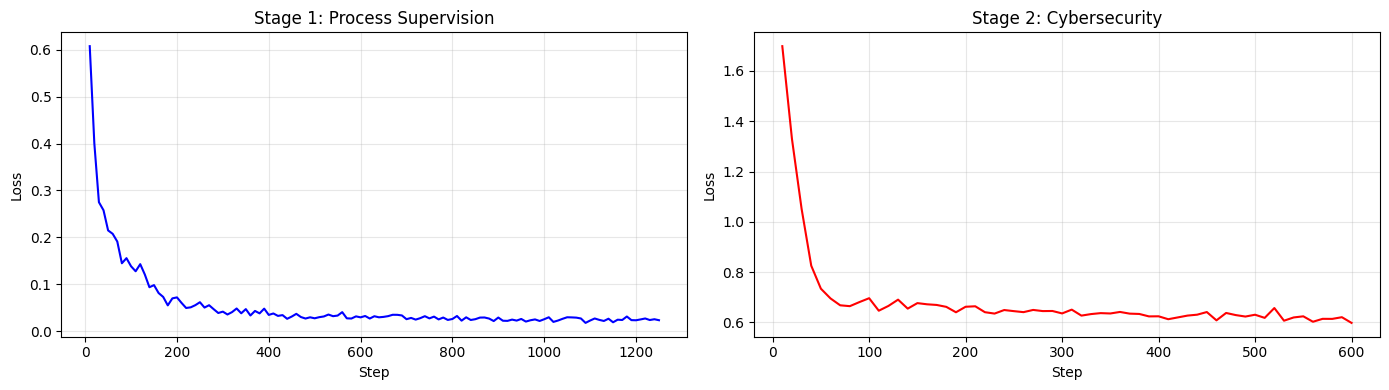

S1: 0.608 -> 0.023 | S2: 1.698 -> 0.598


In [8]:
# Training loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot([l['step'] for l in s1_logs], [l['loss'] for l in s1_logs], 'b-', linewidth=1.5)
ax1.set_title('Stage 1: Process Supervision')
ax1.set_xlabel('Step'); ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

ax2.plot([l['step'] for l in s2_logs], [l['loss'] for l in s2_logs], 'r-', linewidth=1.5)
ax2.set_title('Stage 2: Cybersecurity')
ax2.set_xlabel('Step'); ax2.set_ylabel('Loss')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"S1: {s1_logs[0]['loss']:.3f} -> {s1_logs[-1]['loss']:.3f} | S2: {s2_logs[0]['loss']:.3f} -> {s2_logs[-1]['loss']:.3f}")

In [9]:
# Inference test
FastLanguageModel.for_inference(model)

test_questions = [
    "How do I prevent SQL injection vulnerabilities in a Python Flask application?",
    "What are the security implications of using JWT tokens for authentication?",
    "Explain best practices for detecting and responding to potential data breaches.",
]

for i, q in enumerate(test_questions, 1):
    print(f"\n--- Test {i} ---\nQ: {q}\n")
    messages = [
        {"role": "system", "content": "You are a cybersecurity expert. Verify all advice systematically."},
        {"role": "user", "content": q},
    ]
    inputs = tokenizer.apply_chat_template(
        messages, tokenize=True, add_generation_prompt=True, return_tensors="pt"
    ).to("cuda")

    streamer = TextStreamer(tokenizer, skip_prompt=True)
    _ = model.generate(
        input_ids=inputs,
        streamer=streamer,
        max_new_tokens=512,
        temperature=0.7,
        top_p=0.9,
        use_cache=True,
    )

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Test 1 ---
Q: How do I prevent SQL injection vulnerabilities in a Python Flask application?

Let me provide thoroughly verified guidance.

**Step 1 - Initial Analysis:**
SQL injection is an attack that occurs when an attacker provides malicious data to your database, which can be used to compromise the server’s integrity and functionality. The most common way for attackers to perform this type of attack involves injecting code into web forms or URL parameters where they expect input from users (like usernames) but instead receive arbitrary commands written by them. This type of vulnerability exists because developers often fail to validate user inputs before storing them in their applications’ databases. If not properly handled, these unvalidated inputs could lead to SQL queries containing malicious code executed on behalf of the victim’s system by other parts of the same application or even outside it via external connections such as APIs. To protect against this threat, develope

In [10]:
# Save LoRA adapters
model.save_pretrained("cove_cybersec_lora")
tokenizer.save_pretrained("cove_cybersec_lora")

import os
for f in os.listdir("cove_cybersec_lora"):
    size = os.path.getsize(f"cove_cybersec_lora/{f}") / 1024**2
    print(f"  {f}: {size:.1f} MB" if size > 0.1 else f"  {f}: {os.path.getsize(f'cove_cybersec_lora/{f}')//1024} KB")

  merges.txt: 1.6 MB
  README.md: 5 KB
  added_tokens.json: 0 KB
  special_tokens_map.json: 0 KB
  tokenizer.json: 10.9 MB
  chat_template.jinja: 2 KB
  adapter_config.json: 1 KB
  adapter_model.safetensors: 70.5 MB
  tokenizer_config.json: 4 KB
  vocab.json: 2.6 MB
